# 1.9f: Adjacency Graph of the 13 Black Holes

From 1.9e we know that 58.6% of black hole separations are single-bit flips (uint16 separation = 1).

**Question:** What is the connectivity structure of the 13 black holes?

**Method:**
1. Define adjacency: two BHs are adjacent if they differ by 1 uint16 step in ≥1 dimension
2. Build adjacency graph (nodes = BHs, edges = adjacency relationships)
3. Compute graph properties:
   - Connected components (is it one structure or multiple?)
   - Degree distribution (how many neighbors does each BH have?)
   - Diameter (longest shortest path)
   - Clustering coefficient (how clique-like?)
   - Betweenness centrality (which BHs are bridges/hubs?)
4. Visualize the graph structure
5. Search for symmetries (graph automorphisms)

This reveals the **formation signature** of the primordial black hole cluster.

## Parameters

In [1]:
# Model to analyze
MODEL_NAME = "Qwen3-4B-Instruct-2507"

# Active dimensions from 1.9c
ACTIVE_DIMS = [216, 282, 322, 450, 993, 1008, 1149, 1155, 1272, 1382, 
               1403, 1435, 1487, 1564, 1763, 2012, 2040, 2079, 2143, 2479]

## Imports

In [2]:
import torch
import ml_dtypes
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from safetensors.torch import load_file
from pathlib import Path
from collections import defaultdict, Counter

## Load Data

In [3]:
# Load W in bfloat16
W_path = Path(f"../tensors/{MODEL_NAME}/W.safetensors")
W_bf16 = load_file(W_path)["W"]

print(f"Loaded W: {W_bf16.shape}")
print(f"Dtype: {W_bf16.dtype}")

Loaded W: torch.Size([151936, 2560])
Dtype: torch.bfloat16


In [4]:
# Load corrected core data from 1.9b
core_path = Path(f"../tensors/{MODEL_NAME}/1.9b_core_bfloat16.safetensors")
core_data = load_file(core_path)

core_token_ids = core_data["core_token_ids"].to(torch.int64)
bh_labels = core_data["bh_labels"].to(torch.int64)
n_black_holes = core_data["n_black_holes"].item()

print(f"\nLoaded core data: {n_black_holes} black holes")


Loaded core data: 13 black holes


## Extract Black Hole Representative Vectors

In [5]:
print("\nExtracting black hole representative vectors...\n")

# For each black hole, get the first token
bh_token_ids = []
bh_populations = []

for bh_id in range(n_black_holes):
    mask = bh_labels == bh_id
    tokens_in_bh = core_token_ids[mask]
    bh_token_ids.append(tokens_in_bh[0].item())
    bh_populations.append(len(tokens_in_bh))
    print(f"BH{bh_id:2d}: {len(tokens_in_bh):4,} tokens")

# Extract vectors in bfloat16
bh_vectors_bf16 = [W_bf16[token_id] for token_id in bh_token_ids]

# Convert to uint16 (raw bits)
bh_vectors_uint16 = [vec.cpu().view(torch.uint16).numpy() for vec in bh_vectors_bf16]

print(f"\n✓ Extracted {len(bh_vectors_bf16)} black hole vectors")
print(f"  Converted to uint16 (raw bits)")


Extracting black hole representative vectors...

BH 0:  814 tokens
BH 1:  704 tokens
BH 2:  306 tokens
BH 3:  228 tokens
BH 4:   11 tokens
BH 5:   10 tokens
BH 6:    6 tokens
BH 7:    5 tokens
BH 8:    4 tokens
BH 9:    4 tokens
BH10:    3 tokens
BH11:    3 tokens
BH12:    2 tokens

✓ Extracted 13 black hole vectors
  Converted to uint16 (raw bits)


## Build Adjacency Matrix

In [6]:
print("\nBuilding adjacency matrix...\n")

# Adjacency matrix: adj[i][j] = 1 if BH_i and BH_j are adjacent (differ by 1 uint16 in ≥1 dimension)
adj_matrix = np.zeros((n_black_holes, n_black_holes), dtype=bool)

# Also track which dimensions contribute to adjacency
adjacency_dims = defaultdict(list)  # (i, j) -> list of dimensions where they're adjacent

for dim in ACTIVE_DIMS:
    # Extract uint16 values for this dimension
    values_uint16 = [vec[dim] for vec in bh_vectors_uint16]
    
    # Check all pairs
    for i in range(n_black_holes):
        for j in range(i+1, n_black_holes):
            # Skip if identical in this dimension
            if values_uint16[i] == values_uint16[j]:
                continue
            
            # Check if separated by exactly 1 uint16 step
            uint16_sep = abs(int(values_uint16[i]) - int(values_uint16[j]))
            if uint16_sep == 1:
                adj_matrix[i, j] = True
                adj_matrix[j, i] = True
                adjacency_dims[(i, j)].append(dim)

# Count edges
n_edges = np.sum(adj_matrix) // 2  # Divide by 2 because matrix is symmetric

print(f"✓ Adjacency matrix built")
print(f"  Edges: {n_edges} adjacency relationships")
print(f"  Max possible edges: {n_black_holes * (n_black_holes - 1) // 2}")
print(f"  Edge density: {n_edges / (n_black_holes * (n_black_holes - 1) // 2) * 100:.1f}%")


Building adjacency matrix...

✓ Adjacency matrix built
  Edges: 78 adjacency relationships
  Max possible edges: 78
  Edge density: 100.0%


## Create NetworkX Graph

In [7]:
print("\nCreating NetworkX graph...\n")

# Create graph
G = nx.Graph()

# Add nodes with population as attribute
for i in range(n_black_holes):
    G.add_node(i, population=bh_populations[i])

# Add edges with dimensions as attribute
for i in range(n_black_holes):
    for j in range(i+1, n_black_holes):
        if adj_matrix[i, j]:
            dims = adjacency_dims[(i, j)]
            G.add_edge(i, j, dimensions=dims, n_dims=len(dims))

print(f"✓ Graph created")
print(f"  Nodes: {G.number_of_nodes()}")
print(f"  Edges: {G.number_of_edges()}")


Creating NetworkX graph...

✓ Graph created
  Nodes: 13
  Edges: 78


## Connected Components

In [8]:
print("\n" + "=" * 100)
print("CONNECTED COMPONENTS")
print("=" * 100)
print()

# Find connected components
components = list(nx.connected_components(G))
n_components = len(components)

print(f"Number of connected components: {n_components}")
print()

if n_components == 1:
    print("✓ All 13 black holes form a SINGLE CONNECTED STRUCTURE.")
    print("  Every BH can be reached from every other via adjacency paths.")
    print("  This suggests a unified formation event.")
else:
    print(f"Multiple components detected ({n_components} separate structures).")
    print()
    for idx, component in enumerate(sorted(components, key=len, reverse=True), 1):
        bh_ids = sorted(component)
        total_pop = sum(bh_populations[i] for i in bh_ids)
        print(f"  Component {idx}: {len(component)} black holes")
        print(f"    BH IDs: {bh_ids}")
        print(f"    Total population: {total_pop:,} tokens")
        print()


CONNECTED COMPONENTS

Number of connected components: 1

✓ All 13 black holes form a SINGLE CONNECTED STRUCTURE.
  Every BH can be reached from every other via adjacency paths.
  This suggests a unified formation event.


## Graph Properties

In [9]:
print("\n" + "=" * 100)
print("GRAPH PROPERTIES")
print("=" * 100)
print()

# Degree distribution
degrees = dict(G.degree())
degree_values = list(degrees.values())

print("Degree Statistics:")
print(f"  Mean degree: {np.mean(degree_values):.2f}")
print(f"  Median degree: {np.median(degree_values):.0f}")
print(f"  Min degree: {np.min(degree_values)}")
print(f"  Max degree: {np.max(degree_values)}")
print()

# Per-node degrees
print("Per-node degrees:")
for i in sorted(degrees.keys()):
    print(f"  BH{i:2d}: degree = {degrees[i]:2d}  (population = {bh_populations[i]:4,})")
print()

# Diameter (only if connected)
if nx.is_connected(G):
    diameter = nx.diameter(G)
    print(f"Diameter: {diameter}")
    print(f"  (Longest shortest path between any two nodes)")
    print()
else:
    print("Diameter: undefined (graph is not connected)")
    print()

# Clustering coefficient
clustering = nx.average_clustering(G)
print(f"Average clustering coefficient: {clustering:.3f}")
print(f"  (0 = tree-like, 1 = complete graph/clique)")
print()

# Check if complete graph
max_edges = n_black_holes * (n_black_holes - 1) // 2
is_complete = G.number_of_edges() == max_edges
if is_complete:
    print("✓ Graph is COMPLETE (every BH adjacent to every other).")
    print("  This is the densest possible packing.")
else:
    print(f"Graph is NOT complete.")
    print(f"  Missing edges: {max_edges - G.number_of_edges()} / {max_edges}")


GRAPH PROPERTIES

Degree Statistics:
  Mean degree: 12.00
  Median degree: 12
  Min degree: 12
  Max degree: 12

Per-node degrees:
  BH 0: degree = 12  (population =  814)
  BH 1: degree = 12  (population =  704)
  BH 2: degree = 12  (population =  306)
  BH 3: degree = 12  (population =  228)
  BH 4: degree = 12  (population =   11)
  BH 5: degree = 12  (population =   10)
  BH 6: degree = 12  (population =    6)
  BH 7: degree = 12  (population =    5)
  BH 8: degree = 12  (population =    4)
  BH 9: degree = 12  (population =    4)
  BH10: degree = 12  (population =    3)
  BH11: degree = 12  (population =    3)
  BH12: degree = 12  (population =    2)

Diameter: 1
  (Longest shortest path between any two nodes)

Average clustering coefficient: 1.000
  (0 = tree-like, 1 = complete graph/clique)

✓ Graph is COMPLETE (every BH adjacent to every other).
  This is the densest possible packing.


## Centrality Analysis

In [10]:
print("\n" + "=" * 100)
print("CENTRALITY ANALYSIS")
print("=" * 100)
print()

# Betweenness centrality (which nodes are bridges?)
if nx.is_connected(G):
    betweenness = nx.betweenness_centrality(G)
    
    print("Betweenness Centrality (which BHs are bridges/hubs?):")
    for i in sorted(betweenness.keys(), key=lambda x: betweenness[x], reverse=True):
        print(f"  BH{i:2d}: {betweenness[i]:.3f}")
    print()
    
    # Identify hub(s)
    max_betweenness = max(betweenness.values())
    hubs = [i for i, b in betweenness.items() if b == max_betweenness]
    if max_betweenness > 0:
        print(f"Hub(s) (highest betweenness): {['BH'+str(i) for i in hubs]}")
    else:
        print("No hubs detected (all betweenness = 0, likely a complete graph).")
else:
    print("Betweenness centrality: undefined (graph is not connected)")

print()

# Closeness centrality (average distance to all other nodes)
if nx.is_connected(G):
    closeness = nx.closeness_centrality(G)
    
    print("Closeness Centrality (which BHs are most central?):")
    for i in sorted(closeness.keys(), key=lambda x: closeness[x], reverse=True)[:5]:
        print(f"  BH{i:2d}: {closeness[i]:.3f}")
else:
    print("Closeness centrality: undefined (graph is not connected)")


CENTRALITY ANALYSIS

Betweenness Centrality (which BHs are bridges/hubs?):
  BH 0: 0.000
  BH 1: 0.000
  BH 2: 0.000
  BH 3: 0.000
  BH 4: 0.000
  BH 5: 0.000
  BH 6: 0.000
  BH 7: 0.000
  BH 8: 0.000
  BH 9: 0.000
  BH10: 0.000
  BH11: 0.000
  BH12: 0.000

No hubs detected (all betweenness = 0, likely a complete graph).

Closeness Centrality (which BHs are most central?):
  BH 0: 1.000
  BH 1: 1.000
  BH 2: 1.000
  BH 3: 1.000
  BH 4: 1.000


## Edge Weight Analysis

In [11]:
print("\n" + "=" * 100)
print("EDGE WEIGHT ANALYSIS (Multi-dimensional Adjacency)")
print("=" * 100)
print()

# Count how many dimensions contribute to each edge
edge_weights = [data['n_dims'] for _, _, data in G.edges(data=True)]

print("Edge weights (number of dimensions where BHs are adjacent):")
weight_counts = Counter(edge_weights)
for weight in sorted(weight_counts.keys()):
    count = weight_counts[weight]
    pct = 100 * count / len(edge_weights)
    print(f"  {weight} dimension(s): {count:3d} edges ({pct:5.1f}%)")

print()
print(f"Mean edge weight: {np.mean(edge_weights):.2f} dimensions/edge")
print(f"Max edge weight: {np.max(edge_weights)} dimensions")
print()

# Find heaviest edges (adjacent in many dimensions)
heaviest_edges = sorted(G.edges(data=True), key=lambda x: x[2]['n_dims'], reverse=True)[:5]

print("Heaviest edges (adjacent in most dimensions):")
for i, j, data in heaviest_edges:
    print(f"  BH{i:2d} - BH{j:2d}: adjacent in {data['n_dims']} dimensions {data['dimensions'][:3]}...")


EDGE WEIGHT ANALYSIS (Multi-dimensional Adjacency)

Edge weights (number of dimensions where BHs are adjacent):
  1 dimension(s):   9 edges ( 11.5%)
  2 dimension(s):  10 edges ( 12.8%)
  3 dimension(s):  15 edges ( 19.2%)
  4 dimension(s):  15 edges ( 19.2%)
  5 dimension(s):   9 edges ( 11.5%)
  6 dimension(s):   6 edges (  7.7%)
  7 dimension(s):   2 edges (  2.6%)
  8 dimension(s):   1 edges (  1.3%)
  9 dimension(s):   6 edges (  7.7%)
  10 dimension(s):   2 edges (  2.6%)
  11 dimension(s):   2 edges (  2.6%)
  12 dimension(s):   1 edges (  1.3%)

Mean edge weight: 4.42 dimensions/edge
Max edge weight: 12 dimensions

Heaviest edges (adjacent in most dimensions):
  BH 9 - BH12: adjacent in 12 dimensions [282, 450, 993]...
  BH 1 - BH 9: adjacent in 11 dimensions [282, 450, 993]...
  BH 4 - BH 9: adjacent in 11 dimensions [216, 282, 450]...
  BH 3 - BH 9: adjacent in 10 dimensions [282, 450, 993]...
  BH 6 - BH 9: adjacent in 10 dimensions [216, 282, 450]...


## Visualizations


Creating visualizations...



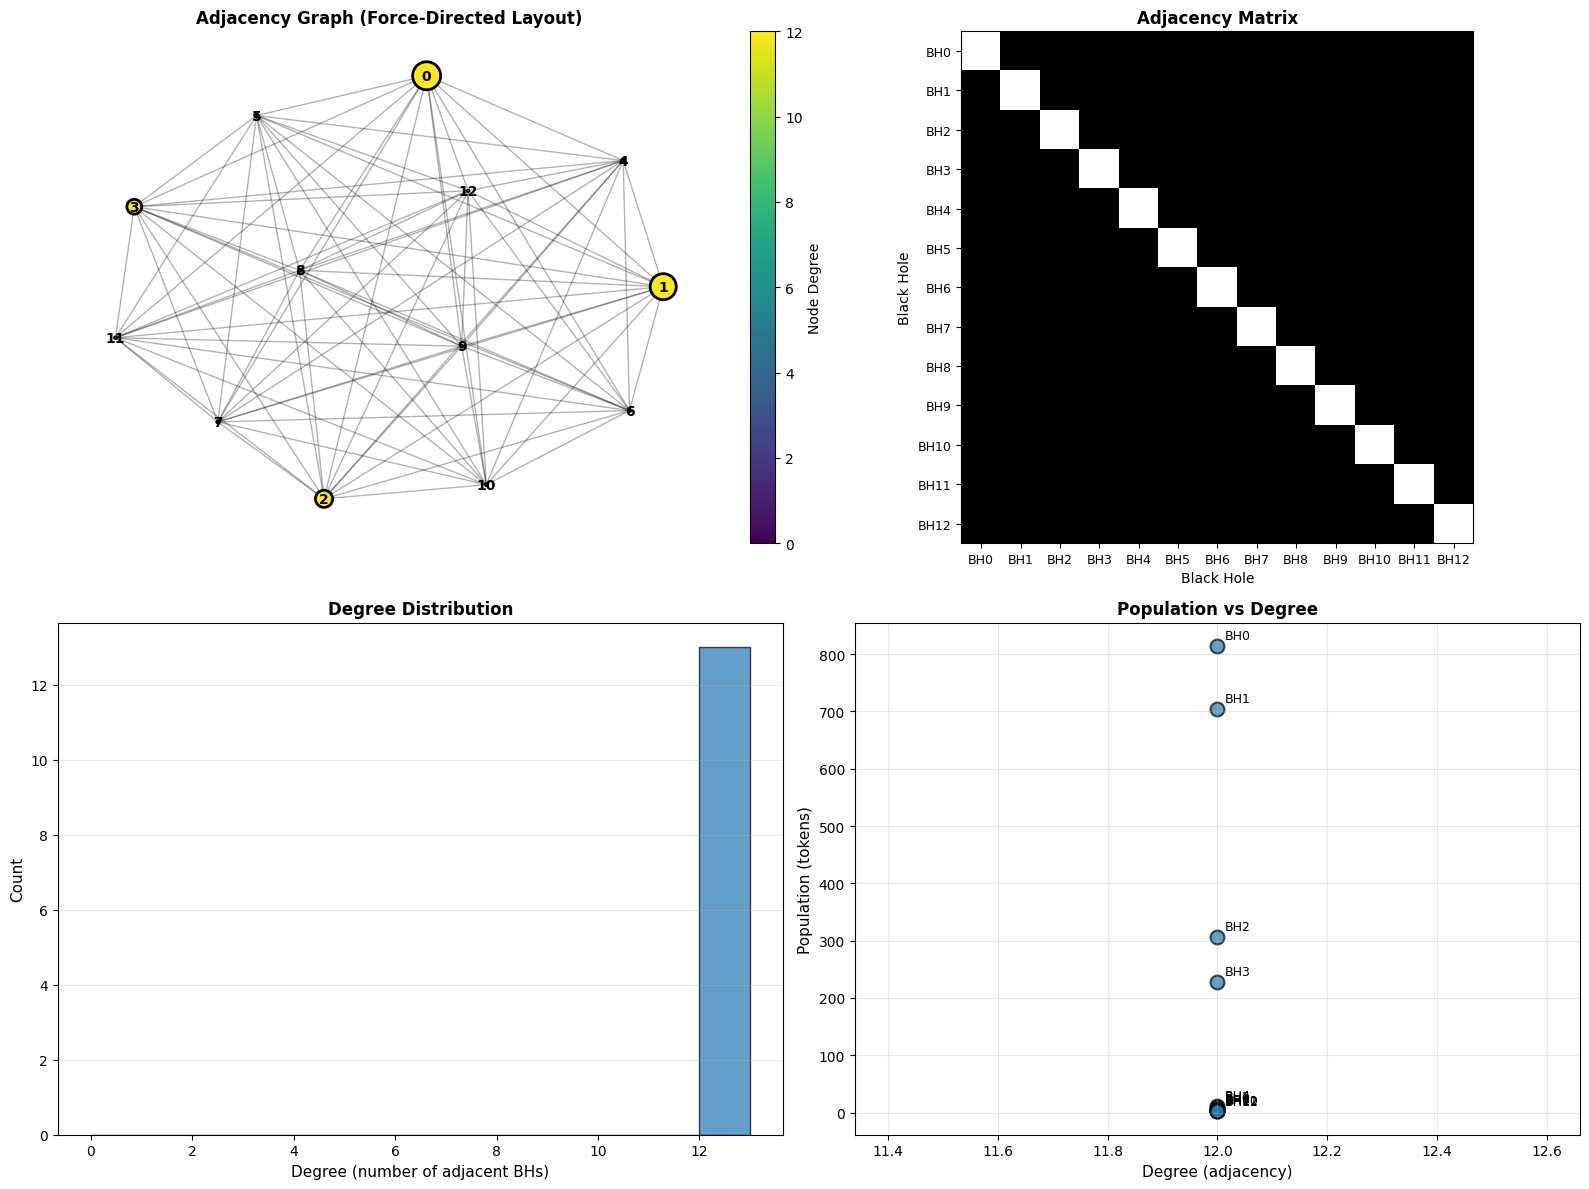

✓ Visualizations complete


In [12]:
print("\nCreating visualizations...\n")

fig = plt.figure(figsize=(16, 12), dpi=100)

# 1. Network graph (force-directed layout)
ax1 = plt.subplot(2, 2, 1)

# Use spring layout for force-directed positioning
pos = nx.spring_layout(G, seed=42, k=0.5, iterations=50)

# Node sizes proportional to population
node_sizes = [bh_populations[i] for i in range(n_black_holes)]
node_sizes_scaled = [s * 0.5 for s in node_sizes]  # Scale for visibility

# Node colors by degree
node_colors = [degrees[i] for i in range(n_black_holes)]

# Draw
nx.draw_networkx_nodes(G, pos, node_size=node_sizes_scaled, node_color=node_colors, 
                       cmap='viridis', vmin=0, vmax=max(degrees.values()), 
                       edgecolors='black', linewidths=2, ax=ax1)
nx.draw_networkx_edges(G, pos, alpha=0.3, width=1, ax=ax1)
nx.draw_networkx_labels(G, pos, font_size=10, font_weight='bold', ax=ax1)

ax1.set_title('Adjacency Graph (Force-Directed Layout)', fontsize=12, fontweight='bold')
ax1.axis('off')

# Add colorbar
sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=0, vmax=max(degrees.values())))
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax1, fraction=0.046, pad=0.04)
cbar.set_label('Node Degree', fontsize=10)

# 2. Adjacency matrix heatmap
ax2 = plt.subplot(2, 2, 2)
im = ax2.imshow(adj_matrix.astype(int), cmap='binary', interpolation='nearest')
ax2.set_xticks(range(n_black_holes))
ax2.set_yticks(range(n_black_holes))
ax2.set_xticklabels([f'BH{i}' for i in range(n_black_holes)], fontsize=9)
ax2.set_yticklabels([f'BH{i}' for i in range(n_black_holes)], fontsize=9)
ax2.set_title('Adjacency Matrix', fontsize=12, fontweight='bold')
ax2.set_xlabel('Black Hole', fontsize=10)
ax2.set_ylabel('Black Hole', fontsize=10)

# 3. Degree distribution histogram
ax3 = plt.subplot(2, 2, 3)
ax3.hist(degree_values, bins=range(0, max(degree_values)+2), edgecolor='black', alpha=0.7)
ax3.set_xlabel('Degree (number of adjacent BHs)', fontsize=11)
ax3.set_ylabel('Count', fontsize=11)
ax3.set_title('Degree Distribution', fontsize=12, fontweight='bold')
ax3.grid(axis='y', alpha=0.3)

# 4. Population vs Degree scatter
ax4 = plt.subplot(2, 2, 4)
ax4.scatter(degree_values, bh_populations, s=100, alpha=0.7, edgecolors='black', linewidths=1.5)

# Label points
for i in range(n_black_holes):
    ax4.annotate(f'BH{i}', (degrees[i], bh_populations[i]), 
                xytext=(5, 5), textcoords='offset points', fontsize=9)

ax4.set_xlabel('Degree (adjacency)', fontsize=11)
ax4.set_ylabel('Population (tokens)', fontsize=11)
ax4.set_title('Population vs Degree', fontsize=12, fontweight='bold')
ax4.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("✓ Visualizations complete")

## Symmetry Detection (Graph Automorphisms)

In [13]:
print("\n" + "=" * 100)
print("SYMMETRY DETECTION (Graph Automorphisms)")
print("=" * 100)
print()

# Check for structurally equivalent nodes (nodes with identical neighborhoods)
# These are candidates for automorphisms

print("Structural equivalence classes:")
print("(Nodes with identical degree and neighbor degrees)")
print()

# Group nodes by their structural signature
structural_signatures = {}
for i in range(n_black_holes):
    # Signature: (degree, sorted neighbor degrees)
    neighbors = list(G.neighbors(i))
    neighbor_degrees = sorted([degrees[n] for n in neighbors])
    signature = (degrees[i], tuple(neighbor_degrees))
    
    if signature not in structural_signatures:
        structural_signatures[signature] = []
    structural_signatures[signature].append(i)

# Report equivalence classes
n_classes = len(structural_signatures)
print(f"Number of structural equivalence classes: {n_classes}")
print()

for idx, (signature, nodes) in enumerate(sorted(structural_signatures.items(), 
                                                 key=lambda x: len(x[1]), reverse=True), 1):
    degree, neighbor_degrees = signature
    print(f"Class {idx}: {len(nodes)} node(s)")
    print(f"  Nodes: {['BH'+str(i) for i in nodes]}")
    print(f"  Degree: {degree}")
    print(f"  Neighbor degrees: {list(neighbor_degrees)}")
    print()

# If multiple nodes in any class, there's potential symmetry
symmetric_classes = [nodes for nodes in structural_signatures.values() if len(nodes) > 1]
if symmetric_classes:
    print(f"✓ Potential symmetries detected: {len(symmetric_classes)} equivalence classes with >1 node.")
    print(f"  These nodes are structurally identical (could be swapped without changing the graph).")
else:
    print("No symmetries detected. All nodes are structurally unique.")


SYMMETRY DETECTION (Graph Automorphisms)

Structural equivalence classes:
(Nodes with identical degree and neighbor degrees)

Number of structural equivalence classes: 1

Class 1: 13 node(s)
  Nodes: ['BH0', 'BH1', 'BH2', 'BH3', 'BH4', 'BH5', 'BH6', 'BH7', 'BH8', 'BH9', 'BH10', 'BH11', 'BH12']
  Degree: 12
  Neighbor degrees: [12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12]

✓ Potential symmetries detected: 1 equivalence classes with >1 node.
  These nodes are structurally identical (could be swapped without changing the graph).


## Summary: Formation Signature

In [14]:
print("\n" + "=" * 100)
print("SUMMARY: FORMATION SIGNATURE")
print("=" * 100)
print()

print("The 13 black holes form an adjacency graph with the following properties:")
print()

# Connectivity
if n_components == 1:
    print("✓ SINGLE CONNECTED COMPONENT")
    print("  All black holes are linked by adjacency paths.")
    print("  Interpretation: Unified formation event.")
else:
    print(f"⚠ MULTIPLE COMPONENTS ({n_components} separate structures)")
    print("  Interpretation: Multiple independent formation events or one event with internal fragmentation.")

print()

# Density
edge_density = n_edges / (n_black_holes * (n_black_holes - 1) // 2)
if edge_density > 0.8:
    print(f"✓ VERY HIGH EDGE DENSITY ({edge_density*100:.1f}%)")
    print("  Nearly complete graph (most BHs adjacent to most others).")
    print("  Interpretation: Extremely tight packing, minimal separation.")
elif edge_density > 0.5:
    print(f"✓ HIGH EDGE DENSITY ({edge_density*100:.1f}%)")
    print("  Interpretation: Dense cluster with strong internal connectivity.")
elif edge_density > 0.2:
    print(f"MODERATE EDGE DENSITY ({edge_density*100:.1f}%)")
    print("  Interpretation: Structured but not maximally dense.")
else:
    print(f"LOW EDGE DENSITY ({edge_density*100:.1f}%)")
    print("  Interpretation: Sparse, tree-like or elongated structure.")

print()

# Clustering
if clustering > 0.8:
    print(f"✓ HIGH CLUSTERING COEFFICIENT ({clustering:.3f})")
    print("  Neighbors of a node tend to be neighbors of each other (clique-like).")
    print("  Interpretation: Tight ball, not tree or chain.")
elif clustering > 0.5:
    print(f"MODERATE CLUSTERING ({clustering:.3f})")
    print("  Some local clique structure.")
else:
    print(f"LOW CLUSTERING ({clustering:.3f})")
    print("  Tree-like or chain-like structure.")

print()

# Diameter
if nx.is_connected(G):
    if diameter == 1:
        print(f"✓ DIAMETER = 1 (COMPLETE GRAPH)")
        print("  Every BH directly adjacent to every other.")
        print("  Interpretation: Maximally dense packing.")
    elif diameter == 2:
        print(f"✓ DIAMETER = 2")
        print("  Any BH reachable from any other in ≤2 hops.")
        print("  Interpretation: Tight cluster (small-world structure).")
    else:
        print(f"DIAMETER = {diameter}")
        print("  Elongated structure (chain or filament).")

print()

# Symmetry
if symmetric_classes:
    print(f"✓ SYMMETRIES DETECTED ({len(symmetric_classes)} equivalence classes)")
    print("  Some BHs are structurally identical (interchangeable).")
    print("  Interpretation: Regular structure, not random scatter.")
else:
    print("NO SYMMETRIES DETECTED")
    print("  All BHs structurally unique.")
    print("  Interpretation: Irregular or highly specific geometry.")

print()
print("=" * 100)
print()

# Final interpretation
print("FORMATION HYPOTHESIS:")
print()

if n_components == 1 and edge_density > 0.8 and clustering > 0.8:
    print("The 13 black holes form a SINGLE TIGHT CLUSTER with very high connectivity.")
    print("This structure is consistent with:")
    print("  • A single initialization event creating all 13 BHs simultaneously")
    print("  • Packing as tightly as bfloat16 precision allows (single-bit separations)")
    print("  • A primordial nucleus that resisted gradient updates during training")
    print()
    print("Recommended next steps:")
    print("  • Examine initialization algorithm (e.g., Xavier, Kaiming He) to see if it")
    print("    naturally produces tight clusters of near-identical values")
    print("  • Check training dynamics: why didn't gradients break up this cluster?")
    print("  • Search for similar structures in other models with same architecture")
elif n_components > 1:
    print("The black holes form MULTIPLE DISCONNECTED COMPONENTS.")
    print("This suggests:")
    print("  • Multiple independent initialization seeds, OR")
    print("  • One cluster that fragmented during early training")
    print()
    print("Recommended: Analyze each component separately to understand their individual structures.")
else:
    print("The structure shows intermediate properties (connected but not maximally dense).")
    print("Further analysis needed to determine formation mechanism.")

print()
print("=" * 100)


SUMMARY: FORMATION SIGNATURE

The 13 black holes form an adjacency graph with the following properties:

✓ SINGLE CONNECTED COMPONENT
  All black holes are linked by adjacency paths.
  Interpretation: Unified formation event.

✓ VERY HIGH EDGE DENSITY (100.0%)
  Nearly complete graph (most BHs adjacent to most others).
  Interpretation: Extremely tight packing, minimal separation.

✓ HIGH CLUSTERING COEFFICIENT (1.000)
  Neighbors of a node tend to be neighbors of each other (clique-like).
  Interpretation: Tight ball, not tree or chain.

✓ DIAMETER = 1 (COMPLETE GRAPH)
  Every BH directly adjacent to every other.
  Interpretation: Maximally dense packing.

✓ SYMMETRIES DETECTED (1 equivalence classes)
  Some BHs are structurally identical (interchangeable).
  Interpretation: Regular structure, not random scatter.


FORMATION HYPOTHESIS:

The 13 black holes form a SINGLE TIGHT CLUSTER with very high connectivity.
This structure is consistent with:
  • A single initialization event cre